Tutorial : https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html

In [2]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

C:\Anaconda3\envs\pymc\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Import data

In [3]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

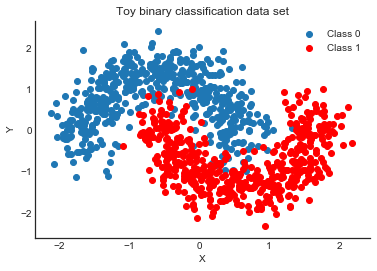

In [4]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');


In [6]:
#Store training data in theano variables
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

# Model Specification

In [7]:
total_size = len(Y_train)
n_hidden = 5

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_out = np.random.randn(n_hidden).astype(floatX)

def build_network(ann_input, ann_output):
    with pm.Model() as model:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=total_size)

    return model, out

In [ ]:
from six.moves import zip

def train_sgfs(model, B=None):

    # Tensors and RV that will be using mini-batches
    minibatch_tensors = [ann_input, ann_output]
    minibatch_RVs = [out]

    # Generator that returns mini-batches in each iteration
    def create_minibatch(data):
        rng = np.random.RandomState(0)

        while True:
            # Return random data samples of set size 50 each iteration
            ixs = rng.randint(len(data), size=50)
            yield data[ixs]

    minibatches = zip(
        create_minibatch(X_train),
        create_minibatch(Y_train),
    )

    total_size = len(Y_train)

    with model:
        draws = 4500
        step_method = pm.SGFS(batch_size=50,
                              total_size=total_size,
                              B=B,
                              step_size=.1,
                              step_size_decay=100,
                              minibatches=minibatches,
                              minibatch_tensors=minibatch_tensors)
        trace = pm.sample(draws=draws, step=step_method)
        return step_method, trace

neural_network, out = build_network(ann_input, ann_output)
%time step_method, trace = train_sgfs(neural_network)


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '1408' (I am process '9008')
C:\Anaconda3\envs\pymc\lib\site-packages\pymc3\step_methods\sgmcmc.py:112: UserWarning: Warning: Stochastic Gradient based sampling methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)


In [ ]:
pm.traceplot(trace);

In [ ]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500, random_seed=0)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [ ]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

# Visualization

In [ ]:
grid = np.mgrid[-3:3:100j,-3:3:100j].astype(floatX)
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [ ]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500, random_seed=0)

In [ ]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
ax.set_title('$B \propto I_t $')
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');